# Feed-forward neural network


Давайте вспомним, что такое нейронные сети прямого распространения. 

Нейронные сети прямого распространения (feed forward neural networks, FF или FFNN) и перцептроны (perceptrons, P) очень прямолинейны, они передают информацию от входа к выходу. Нейронные сети часто описываются в виде слоёного торта, где каждый слой состоит из входных, скрытых или выходных клеток. Клетки одного слоя не связаны между собой, а соседние слои обычно полностью связаны. Самая простая нейронная сеть имеет две входных клетки и одну выходную, и может использоваться в качестве модели логических вентилей. FFNN обычно обучается по методу обратного распространения ошибки, в котором сеть получает множества входных и выходных данных. Этот процесс называется обучением с учителем, и он отличается от обучения без учителя тем, что во втором случае множество выходных данных сеть составляет самостоятельно. Вышеупомянутая ошибка является разницей между вводом и выводом. Если у сети есть достаточное количество скрытых нейронов, она теоретически способна смоделировать взаимодействие между входным и выходными данными. Практически такие сети используются редко, но их часто комбинируют с другими типами для получения новых.

По сути - это последовательность матричных умножений

# Домашнее задание

1. Добиться хорошего результата от модели, собранной на занятии (5 угаданныx картинок из 8 предложенных). Варианты изменений:
- изменение слоёв и их количества;
- изменение метода оптимизации;
- изменение процесса обучения;
- *преобразование данных transform


In [1]:
# !python3 -m pip install scikit-learn

In [2]:
# Сделаем необходимые импорты
import torch
import numpy as np

from torch import nn
import torchvision
import sklearn

In [3]:
import torch.nn.functional as F

In [4]:
from torch import optim

In [5]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt ### воспользуемся для отображения изображения

In [6]:
# Загрузим датасет CIFAR-100

train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                             train=True,  
                                             transform=transforms.ToTensor(), 
                                             download=True)


image, label = train_dataset[0]
print (image.size())
print (label)

Files already downloaded and verified
torch.Size([3, 32, 32])
6


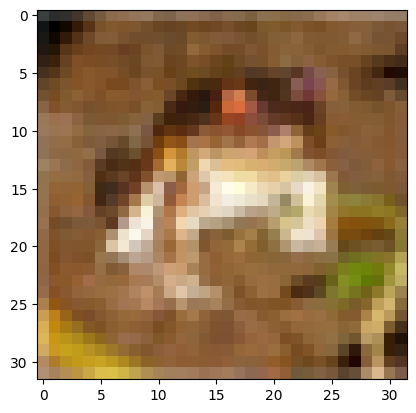

In [7]:
plt.imshow(image.permute(1, 2, 0).numpy())

In [8]:
# создадим dataloader для него
# Если вам не хватает вычислительных ресурсов, то можно вернуться к CIFAR-10

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)

In [9]:
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                         shuffle=False)

Files already downloaded and verified


In [10]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [11]:
3 * 32 * 32

3072

In [12]:
# Создайте собственную архитектуру! Можете использовать все, что угодно, но в ограничении на использование линейные слои (пока без сверток)
# Давайте добавим ограниченный Leaky_relu, то есть output = max(0.1x, 0.5x)
# Ваша задача добавить его в архитектуру сети как функцию активации

import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 4 * hidden_dim)
#         self.fc2 = nn.Linear(4 * hidden_dim, 4 * hidden_dim)
        self.fc2 = nn.Linear(4 * hidden_dim, 2 * hidden_dim)
        self.fc3 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)        # добавии еще один слой

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.leaky_relu(x, 0.05)
        x = self.fc2(x)
        x = F.leaky_relu(x, 0.05)
        x = self.fc3(x)
        x = F.leaky_relu(x, 0.05)
        x = self.fc4(x)
#         x = F.leaky_relu(x, 0.05)
#         x = self.fc5(x)                  # добавии еще один слой
#         x = F.softmax(x)                 # предсказание вероятность кпасса
        return x


net = Net(3072, 100, 10)

In [13]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [14]:
# !pip install tqdm -U

In [15]:
print("Model state_dict: ")
for param in net.state_dict():
    print(param, "\t", net.state_dict()[param].size())

Model state_dict: 
fc1.weight 	 torch.Size([400, 3072])
fc1.bias 	 torch.Size([400])
fc2.weight 	 torch.Size([200, 400])
fc2.bias 	 torch.Size([200])
fc3.weight 	 torch.Size([100, 200])
fc3.bias 	 torch.Size([100])
fc4.weight 	 torch.Size([10, 100])
fc4.bias 	 torch.Size([10])


In [16]:
from tqdm import tqdm

In [17]:
# Запустить обучение (по аналогии с тем, что делали на паре)

for epoch in tqdm(range(40)):  
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Training is finished!')

  0%|                                                                                                                                                                                        | 0/40 [00:00<?, ?it/s]

[1,     1] loss: 0.001
[1,   301] loss: 0.309
[1,   601] loss: 0.282


  2%|████▍                                                                                                                                                                           | 1/40 [00:12<08:01, 12.36s/it]

[2,     1] loss: 0.001
[2,   301] loss: 0.267
[2,   601] loss: 0.262


  5%|████████▊                                                                                                                                                                       | 2/40 [00:24<07:48, 12.34s/it]

[3,     1] loss: 0.001
[3,   301] loss: 0.251
[3,   601] loss: 0.248


  8%|█████████████▏                                                                                                                                                                  | 3/40 [00:37<07:36, 12.35s/it]

[4,     1] loss: 0.001
[4,   301] loss: 0.243
[4,   601] loss: 0.236


 10%|█████████████████▌                                                                                                                                                              | 4/40 [00:49<07:24, 12.36s/it]

[5,     1] loss: 0.001
[5,   301] loss: 0.235
[5,   601] loss: 0.230


 12%|██████████████████████                                                                                                                                                          | 5/40 [01:01<07:12, 12.36s/it]

[6,     1] loss: 0.001
[6,   301] loss: 0.226
[6,   601] loss: 0.225


 15%|██████████████████████████▍                                                                                                                                                     | 6/40 [01:14<07:00, 12.36s/it]

[7,     1] loss: 0.001
[7,   301] loss: 0.220
[7,   601] loss: 0.222


 18%|██████████████████████████████▊                                                                                                                                                 | 7/40 [01:26<06:48, 12.37s/it]

[8,     1] loss: 0.001
[8,   301] loss: 0.218
[8,   601] loss: 0.216


 20%|███████████████████████████████████▏                                                                                                                                            | 8/40 [01:38<06:36, 12.38s/it]

[9,     1] loss: 0.001
[9,   301] loss: 0.213
[9,   601] loss: 0.213


 22%|███████████████████████████████████████▌                                                                                                                                        | 9/40 [01:51<06:23, 12.38s/it]

[10,     1] loss: 0.001
[10,   301] loss: 0.210
[10,   601] loss: 0.209


 25%|███████████████████████████████████████████▊                                                                                                                                   | 10/40 [02:03<06:11, 12.38s/it]

[11,     1] loss: 0.001
[11,   301] loss: 0.207
[11,   601] loss: 0.205


 28%|████████████████████████████████████████████████▏                                                                                                                              | 11/40 [02:16<05:59, 12.39s/it]

[12,     1] loss: 0.001
[12,   301] loss: 0.201
[12,   601] loss: 0.204


 30%|████████████████████████████████████████████████████▌                                                                                                                          | 12/40 [02:28<05:47, 12.39s/it]

[13,     1] loss: 0.001
[13,   301] loss: 0.198
[13,   601] loss: 0.199


 32%|████████████████████████████████████████████████████████▉                                                                                                                      | 13/40 [02:40<05:34, 12.39s/it]

[14,     1] loss: 0.001
[14,   301] loss: 0.194
[14,   601] loss: 0.197


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 14/40 [02:53<05:22, 12.40s/it]

[15,     1] loss: 0.001
[15,   301] loss: 0.194
[15,   601] loss: 0.192


 38%|█████████████████████████████████████████████████████████████████▋                                                                                                             | 15/40 [03:05<05:10, 12.41s/it]

[16,     1] loss: 0.001
[16,   301] loss: 0.190
[16,   601] loss: 0.190


 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 16/40 [03:18<04:57, 12.41s/it]

[17,     1] loss: 0.001
[17,   301] loss: 0.185
[17,   601] loss: 0.186


 42%|██████████████████████████████████████████████████████████████████████████▍                                                                                                    | 17/40 [03:30<04:45, 12.40s/it]

[18,     1] loss: 0.001
[18,   301] loss: 0.183
[18,   601] loss: 0.184


 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 18/40 [03:42<04:32, 12.40s/it]

[19,     1] loss: 0.001
[19,   301] loss: 0.180
[19,   601] loss: 0.182


 48%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 19/40 [03:55<04:20, 12.40s/it]

[20,     1] loss: 0.001
[20,   301] loss: 0.179
[20,   601] loss: 0.178


 50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 20/40 [04:08<04:11, 12.60s/it]

[21,     1] loss: 0.001
[21,   301] loss: 0.176
[21,   601] loss: 0.176


 52%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 21/40 [04:20<03:58, 12.54s/it]

[22,     1] loss: 0.001
[22,   301] loss: 0.174
[22,   601] loss: 0.172


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 22/40 [04:33<03:44, 12.49s/it]

[23,     1] loss: 0.000
[23,   301] loss: 0.170
[23,   601] loss: 0.171


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 23/40 [04:45<03:31, 12.47s/it]

[24,     1] loss: 0.001
[24,   301] loss: 0.167
[24,   601] loss: 0.169


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 24/40 [04:57<03:19, 12.45s/it]

[25,     1] loss: 0.001
[25,   301] loss: 0.166
[25,   601] loss: 0.167


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 25/40 [05:10<03:06, 12.44s/it]

[26,     1] loss: 0.000
[26,   301] loss: 0.162
[26,   601] loss: 0.165


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 26/40 [05:22<02:53, 12.43s/it]

[27,     1] loss: 0.000
[27,   301] loss: 0.160
[27,   601] loss: 0.162


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 27/40 [05:35<02:41, 12.43s/it]

[28,     1] loss: 0.001
[28,   301] loss: 0.157
[28,   601] loss: 0.161


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 28/40 [05:47<02:29, 12.42s/it]

[29,     1] loss: 0.000
[29,   301] loss: 0.158
[29,   601] loss: 0.156


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 29/40 [06:00<02:16, 12.42s/it]

[30,     1] loss: 0.000
[30,   301] loss: 0.157
[30,   601] loss: 0.153


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 30/40 [06:12<02:04, 12.44s/it]

[31,     1] loss: 0.001
[31,   301] loss: 0.152
[31,   601] loss: 0.155


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 31/40 [06:24<01:51, 12.43s/it]

[32,     1] loss: 0.001
[32,   301] loss: 0.150
[32,   601] loss: 0.151


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 32/40 [06:37<01:39, 12.42s/it]

[33,     1] loss: 0.000
[33,   301] loss: 0.150
[33,   601] loss: 0.148


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 33/40 [06:49<01:26, 12.41s/it]

[34,     1] loss: 0.001
[34,   301] loss: 0.146
[34,   601] loss: 0.148


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 34/40 [07:02<01:14, 12.41s/it]

[35,     1] loss: 0.000
[35,   301] loss: 0.144
[35,   601] loss: 0.145


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 35/40 [07:14<01:02, 12.42s/it]

[36,     1] loss: 0.000
[36,   301] loss: 0.141
[36,   601] loss: 0.144


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 36/40 [07:26<00:49, 12.42s/it]

[37,     1] loss: 0.000
[37,   301] loss: 0.138
[37,   601] loss: 0.141


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 37/40 [07:39<00:37, 12.41s/it]

[38,     1] loss: 0.000
[38,   301] loss: 0.137
[38,   601] loss: 0.140


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 38/40 [07:51<00:24, 12.41s/it]

[39,     1] loss: 0.001
[39,   301] loss: 0.136
[39,   601] loss: 0.138


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 39/40 [08:04<00:12, 12.42s/it]

[40,     1] loss: 0.000
[40,   301] loss: 0.135
[40,   601] loss: 0.134


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [08:16<00:00, 12.42s/it]

Training is finished!


In [18]:
_, predicted = torch.max(outputs, 1)

gt = np.array([classes[labels[j]] for j in range(len(labels))])
pred = np.array([classes[predicted[j]] for j in range(len(labels))])

print(gt)
print(pred)
print(f'Accuracy is {(gt == pred).sum() / len(gt)}')
print((gt == pred).sum())
print(len(gt))


['plane' 'plane' 'ship' 'frog' 'dog' 'plane' 'frog' 'plane' 'plane' 'dog'
 'bird' 'car' 'horse' 'plane' 'horse' 'cat']
['car' 'plane' 'plane' 'frog' 'dog' 'car' 'frog' 'cat' 'plane' 'dog'
 'bird' 'car' 'deer' 'plane' 'horse' 'deer']
Accuracy is 0.625
10
16


#### 10 эпох SGD
['frog' 'truck' 'cat' 'horse' 'deer' 'bird' 'ship' 'cat' 'ship' 'bird'
 'deer' 'dog' 'ship' 'car' 'deer' 'deer']
 
['frog' 'truck' 'frog' 'truck' 'frog' 'frog' 'plane' 'ship' 'ship' 'frog'
 'frog' 'frog' 'plane' 'frog' 'frog' 'ship']
 
Accuracy is 0.1875


['ship' 'truck' 'cat' 'bird' 'plane' 'truck' 'truck' 'bird' 'cat' 'car'
 'bird' 'deer' 'dog' 'bird' 'frog' 'frog']
 
['truck' 'cat' 'dog' 'frog' 'plane' 'frog' 'truck' 'truck' 'cat' 'truck'
 'bird' 'deer' 'bird' 'plane' 'frog' 'frog']
 
Accuracy is 0.4375


#### 10 эпох Adam
['horse' 'cat' 'bird' 'bird' 'ship' 'ship' 'ship' 'deer' 'truck' 'ship'
 'cat' 'dog' 'frog' 'dog' 'car' 'ship']
 
['bird' 'ship' 'bird' 'horse' 'ship' 'ship' 'ship' 'bird' 'truck' 'dog'
 'frog' 'horse' 'frog' 'frog' 'car' 'ship']
 
Accuracy is 0.5


#### 40 эпох и увеличели слои и их количество SGD
['horse' 'truck' 'truck' 'plane' 'horse' 'plane' 'deer' 'plane' 'plane'
 'bird' 'car' 'truck' 'bird' 'dog' 'dog' 'horse']
 
['dog' 'truck' 'truck' 'plane' 'plane' 'ship' 'truck' 'plane' 'ship'
 'frog' 'dog' 'truck' 'bird' 'dog' 'dog' 'truck']
 
Accuracy is 0.5

#### 40 эпох Adam
['plane' 'plane' 'ship' 'frog' 'dog' 'plane' 'frog' 'plane' 'plane' 'dog'
 'bird' 'car' 'horse' 'plane' 'horse' 'cat']
 
['car' 'plane' 'plane' 'frog' 'dog' 'car' 'frog' 'cat' 'plane' 'dog'
 'bird' 'car' 'deer' 'plane' 'horse' 'deer']
 
Accuracy is 0.625

#### Для увеличения качества сети изменили оптимайзер и увеличили количество эпох.

#### 2. *Переписать данный туториал на PyTorch: https://www.tensorflow.org/tutorials/quickstart/beginner?hl=ru

In [19]:
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms

In [20]:
# Загрузка данных MNIST
train_set = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

test_set = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

In [21]:
batch_size = 64

# Создание загрузчиков данных
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [22]:
# Определение модели нейронной сети
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNet()

In [23]:
# Определение функции потерь и оптимизатора
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [24]:
# Обучение модели
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (images, labels) in enumerate(dataloader):
        
        # Предсказание и вычисление потерь
        pred = model(images)
        loss = loss_fn(pred, labels)

        # Обратное распространение ошибки
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Вывод прогресса обучения
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(images)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [25]:
# Оценка точности модели
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            pred = model(images)
            test_loss += loss_fn(pred, labels).item()
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()
            
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n")

In [26]:
# Запуск обучения
epochs = 30
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model)
print("Done!")

Epoch 1
-------------------------------
loss: 2.292658  [    0/60000]
loss: 2.284687  [ 6400/60000]
loss: 2.253492  [12800/60000]
loss: 2.262929  [19200/60000]
loss: 2.217932  [25600/60000]
loss: 2.209407  [32000/60000]
loss: 2.155913  [38400/60000]
loss: 2.131993  [44800/60000]
loss: 2.117143  [51200/60000]
loss: 2.066706  [57600/60000]
Test Error: 
 Accuracy: 65.2%, Avg loss: 0.032524

Epoch 2
-------------------------------
loss: 2.085012  [    0/60000]
loss: 2.048440  [ 6400/60000]
loss: 2.064993  [12800/60000]
loss: 1.981053  [19200/60000]
loss: 1.923987  [25600/60000]
loss: 1.936253  [32000/60000]
loss: 1.824584  [38400/60000]
loss: 1.872771  [44800/60000]
loss: 1.813421  [51200/60000]
loss: 1.765161  [57600/60000]
Test Error: 
 Accuracy: 74.0%, Avg loss: 0.027815

Epoch 3
-------------------------------
loss: 1.779042  [    0/60000]
loss: 1.758475  [ 6400/60000]
loss: 1.732747  [12800/60000]
loss: 1.647105  [19200/60000]
loss: 1.667650  [25600/60000]
loss: 1.587543  [32000/60000

loss: 0.399776  [ 6400/60000]
loss: 0.358031  [12800/60000]
loss: 0.504486  [19200/60000]
loss: 0.248959  [25600/60000]
loss: 0.357637  [32000/60000]
loss: 0.259215  [38400/60000]
loss: 0.239699  [44800/60000]
loss: 0.387570  [51200/60000]
loss: 0.359556  [57600/60000]
Test Error: 
 Accuracy: 89.7%, Avg loss: 0.005945

Epoch 23
-------------------------------
loss: 0.619789  [    0/60000]
loss: 0.457664  [ 6400/60000]
loss: 0.416607  [12800/60000]
loss: 0.368338  [19200/60000]
loss: 0.321792  [25600/60000]
loss: 0.355182  [32000/60000]
loss: 0.269640  [38400/60000]
loss: 0.231393  [44800/60000]
loss: 0.447162  [51200/60000]
loss: 0.300278  [57600/60000]
Test Error: 
 Accuracy: 89.9%, Avg loss: 0.005848

Epoch 24
-------------------------------
loss: 0.401335  [    0/60000]
loss: 0.324911  [ 6400/60000]
loss: 0.410548  [12800/60000]
loss: 0.442068  [19200/60000]
loss: 0.322708  [25600/60000]
loss: 0.285692  [32000/60000]
loss: 0.535774  [38400/60000]
loss: 0.492107  [44800/60000]
loss: 